In [18]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
import scipy.interpolate as interpolate

## RG climatology

In [19]:
ds_ct = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Temperature_2019.nc', decode_times=False)
ds_sa = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Salinity_2019.nc', decode_times=False)

(-90.0, 90.0)

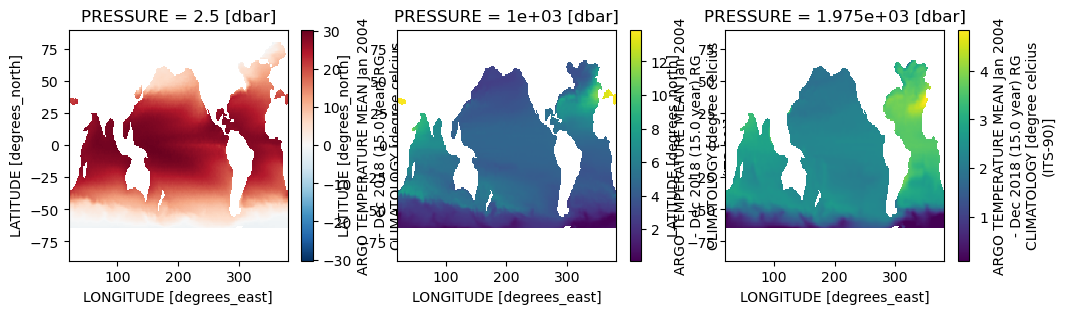

In [26]:
plt.figure(figsize=(12,3))

plt.subplot(131)
ds_ct.ARGO_TEMPERATURE_MEAN.sel(PRESSURE=2.5).plot(x='LONGITUDE',y='LATITUDE')
plt.ylim(-90,90)

plt.subplot(132)
ds_ct.ARGO_TEMPERATURE_MEAN.sel(PRESSURE=1000).plot(x='LONGITUDE',y='LATITUDE')
plt.ylim(-90,90)

plt.subplot(133)
ds_ct.ARGO_TEMPERATURE_MEAN.sel(PRESSURE=1975).plot(x='LONGITUDE',y='LATITUDE')
plt.ylim(-90,90)

In [4]:
# Define correct units and calendar
units = "months since 2004-01-01 00:00:00"
calendar = "360_day"  # Must be 360_day for months-based units

# Convert TIME to datetime
time_values = cftime.num2date(ds_ct.TIME.values, units=units, calendar=calendar)

# Convert to numpy datetime64 for easier handling
ds_ct["TIME"] = xr.DataArray(np.array(time_values, dtype="datetime64[ns]"), dims="TIME")
ds_sa["TIME"] = xr.DataArray(np.array(time_values, dtype="datetime64[ns]"), dims="TIME")

NameError: name 'cftime' is not defined

In [ ]:
ds_ct

In [ ]:
press = 1000
time = '2009-12'

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
data = ds_ct.sel(PRESSURE=press, method='nearest').sel(TIME=time, method='nearest').ARGO_TEMPERATURE_MEAN
data.plot(x='LONGITUDE',y='LATITUDE',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=1, vmax=8)
ax.set_title('Mean Temperature, Press: {}, Time: {}'.format(data.PRESSURE.values, data.TIME.values));

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
data = ds_sa.sel(PRESSURE=press, method='nearest').sel(TIME=time, method='nearest').ARGO_SALINITY_MEAN
data.plot(x='LONGITUDE',y='LATITUDE',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, vmin=34.4, vmax=35.4)
ax.set_title('Mean Salinity, Press: {}, Time: {}'.format(data.PRESSURE.values, data.TIME.values));

## Coordinate intpolation to density

In [3]:
RG_PT = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Temperature_2019.nc', decode_times=False)
RG_PS = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_ArgoClim_Salinity_2019.nc', decode_times=False)

In [4]:
RG_SA = gsw.SA_from_SP(RG_PS.ARGO_SALINITY_MEAN, RG_PS.PRESSURE, RG_PS.LONGITUDE, RG_PS.LATITUDE).rename('SA')
RG_CT = gsw.CT_from_pt(RG_SA, RG_PT.ARGO_TEMPERATURE_MEAN).rename('CT')
RG_SIG0 = gsw.sigma0(RG_SA, RG_CT).rename('SIG0')

In [5]:
RG_p = xr.Dataset(data_vars=dict(CT=(['PRESSURE','LATITUDE','LONGITUDE'], RG_CT.data),
                                 SA=(['PRESSURE','LATITUDE','LONGITUDE'], RG_SA.data),
                                 SIG0=(['PRESSURE','LATITUDE','LONGITUDE'], RG_SIG0.data)),
                  coords=dict(PRESSURE=(['PRESSURE'], RG_PT.PRESSURE.data),
                              LONGITUDE=(['LONGITUDE'], RG_PT.LONGITUDE.data),
                              LATITUDE=(['LATITUDE'], RG_PT.LATITUDE.data)))

In [6]:
RG_p = RG_p.rename({'PRESSURE':'pressure','LATITUDE':'lat','LONGITUDE':'lon'})

In [7]:
RG_p = RG_p.assign_coords(
    lon=(((RG_p.lon + 180) % 360) - 180)
).sortby("lon")


In [8]:
RG_p_interp = RG_p.interp(
    lat=np.arange(-90,91,5),
    lon=np.arange(-180,181,5),
    pressure=np.arange(0,2001,2))

In [9]:
RG_p_interp

<xarray.Dataset> Size: 65MB
Dimensions:   (pressure: 1001, lat: 37, lon: 73)
Coordinates:
  * lat       (lat) int64 296B -90 -85 -80 -75 -70 -65 -60 ... 65 70 75 80 85 90
  * lon       (lon) int64 584B -180 -175 -170 -165 -160 ... 160 165 170 175 180
  * pressure  (pressure) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
Data variables:
    CT        (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan
    SA        (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan
    SIG0      (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan

In [10]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [11]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='prof', dim2='pressure'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['prof', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'prof': ds_z.prof},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(lat  =(dim1, ds_z.lat.data))
    #ds_rho = ds_rho.assign_coords(lon =(dim1, ds_z.lon.data))
    
    return ds_rho

In [12]:
RG_p_stacked = RG_p_interp.stack(prof=("lat", "lon"))

pressure = RG_p_stacked.pressure.data  # shape (1001,)
prof = RG_p_stacked.prof.size      # number of profiles

# Repeat pressure along columns to get shape (1001, prof)
pressure_2d = np.repeat(pressure[:, np.newaxis], prof, axis=1)

# Add as a new variable with fresh name to avoid conflict
RG_p_stacked["PRES"] = (("pressure", "prof"), pressure_2d)

In [13]:
RG_p_stacked_rho = get_ds_rho(RG_p_stacked, RG_p_stacked.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','PRES'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES
Completed PRES
Completed merge


In [14]:
RG_p_interp

<xarray.Dataset> Size: 65MB
Dimensions:   (pressure: 1001, lat: 37, lon: 73)
Coordinates:
  * lat       (lat) int64 296B -90 -85 -80 -75 -70 -65 -60 ... 65 70 75 80 85 90
  * lon       (lon) int64 584B -180 -175 -170 -165 -160 ... 160 165 170 175 180
  * pressure  (pressure) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
Data variables:
    CT        (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan
    SA        (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan
    SIG0      (pressure, lat, lon) float64 22MB nan nan nan nan ... nan nan nan

In [15]:
RG_r = RG_p_stacked_rho.unstack('prof').rename({'rho_grid':'density'})

In [16]:
RG_r

<xarray.Dataset> Size: 277MB
Dimensions:  (lat: 37, lon: 73, density: 3200)
Coordinates:
  * lat      (lat) int64 296B -90 -85 -80 -75 -70 -65 -60 ... 65 70 75 80 85 90
  * lon      (lon) int64 584B -180 -175 -170 -165 -160 ... 160 165 170 175 180
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
Data variables:
    CT       (density, lat, lon) float64 69MB nan nan nan nan ... nan nan nan
    SA       (density, lat, lon) float64 69MB nan nan nan nan ... nan nan nan
    SIG0     (density, lat, lon) float64 69MB nan nan nan nan ... nan nan nan
    PRES     (density, lat, lon) int64 69MB -9223372036854775808 ... -9223372...

In [17]:
RG_p_interp.to_netcdf('/swot/SUM05/amf2288/RG_clim/RG_p_grid5.nc')
RG_r.to_netcdf('/swot/SUM05/amf2288/RG_clim/RG_r_grid5.nc')